# Approximate-Nearest-Neighbors Image Search Pipeline

This notebook details a pipeline for performing approximate nearest neighbors search on a dataset of images by tokenizing the images into vectors using a pre-trained model. The Faiss library is then used for approximate nearest neighbors search. The metric used for the search is euclidean distance.

In [1]:
import os
from PIL import Image
import torch
from torch import nn, optim
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import faiss
import time
from collections import defaultdict
from typing import Tuple, Dict, List
from matplotlib import pyplot as plt
from sklearn.metrics import ndcg_score

C:\Users\renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Data

### Load Sampled Dataset

In [168]:
# Set up the folder paths
dataset_path = "datasets/house_styles"
image_folder = "datasets/house_styles/all_images"

sampled_images = pd.read_csv(os.path.join(dataset_path, "sampled_labels.csv"))
sampled_image_names = sampled_images["file_label"].values

### Select Query Images

In [169]:
# Paired data
pairs_path = os.path.join(dataset_path, "sampled_paired_labels_shuffled.csv")
pairs_df = pd.read_csv(pairs_path)

# count labeled pairs:
tagged_pairs = pairs_df["similarity"].value_counts()
print("Total number of pairs: ", len(pairs_df))
print("Number of labeled pairs: ", tagged_pairs.sum())

Total number of pairs:  101042
Number of labeled pairs:  68093


#### Explore how many tagged pairs are per image in the dataset

Text(0.5, 1.0, 'Distribution of pair counts')

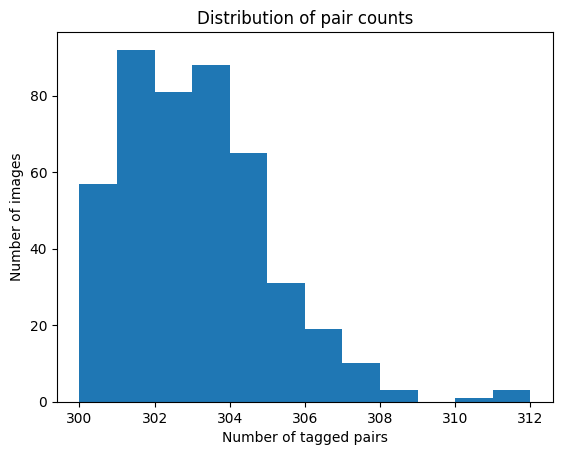

In [5]:
# Count pairs and build relevance judgments in a single pass
pair_counts = defaultdict(int)
relevance_judgments = defaultdict(dict)

# Create temporary lookup array for better performance
pairs_array = pairs_df[['image1', 'image2', 'similarity']].values

for img1, img2, sim in pairs_array:
    if sim in [0,1,2,3]:
        # Update counts
        pair_counts[img1] += 1
        pair_counts[img2] += 1
        
        # Store relevance judgments (both directions)
        relevance_judgments[img1][img2] = sim
        relevance_judgments[img2][img1] = sim

sorted_images_by_count = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)
# print("Images with the most tagged pairs:")
# for img, count in sorted_images_by_count[:50]:
#     print(f"{img}: {count}")

# distribution of pair counts:
pair_counts_values = list(pair_counts.values())
plt.hist(pair_counts_values, bins=12)
plt.xlabel("Number of tagged pairs")
plt.ylabel("Number of images")
plt.title("Distribution of pair counts")


In [185]:
### Select queries by highest number of tagged pairs:

n_queries = 50

# Get the n_queries images with the lowest number of pairs
queries = sorted_images_by_count[:n_queries]
print("highest pair count: ", queries[0][1])
print("lowest pair count: ", queries[-1][1])

print()

query_image_names = [img for img, _ in queries]
index_image_names = [img for img, _ in sorted_images_by_count[n_queries:]]

print("Number of queries: ", len(query_image_names))
print("Number of index images: ", len(index_image_names))

highest pair count:  312
lowest pair count:  305

Number of queries:  50
Number of index images:  400


In [188]:
### Select queries randomly to remove bias:

n_queries = 50
np.random.seed(42)

# get random queries:
queries = list(np.random.choice(sampled_image_names, n_queries, replace=False))
print("highest pair count: ", max([pair_counts[q] for q in queries]))
print("lowest pair count: ", min([pair_counts[q] for q in queries]))

print()

query_image_names = queries
index_image_names = [img for img in sampled_image_names if img not in queries]

print("Number of queries: ", len(query_image_names))
print("Number of index images: ", len(index_image_names))

highest pair count:  308
lowest pair count:  300

Number of queries:  50
Number of index images:  400


## Embedding Models

In [117]:
# Set up device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Load Computer Vision Model

In [118]:
# Load the pretrained CLIP model and processor from Hugging Face
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Set up the image transformation pipeline
clip_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


/Users/naomi/miniconda3/envs/Lab2_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Load Fine-Tuned Model

In [119]:
class SiameseNetworkEmbedder(nn.Module):
    """ As shown in active_learning_pipeline.ipynb,
     with the addition of a forward_one method to get the embedding of a single image. """
    def __init__(self):
        super(SiameseNetworkEmbedder, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.relu = nn.ReLU()

    def forward_one(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
    
    def get_embedding(self, x):
        return self.forward_one(x)

siamese_model = SiameseNetworkEmbedder()
siamese_model.load_state_dict(torch.load("active_learning_models/net_round4.pth", map_location=torch.device(device)))

<All keys matched successfully>

### Embed Images

In [187]:
def load_and_preprocess_image(image_path):
    """
    Loads an image from the specified file path and preprocesses it for use with the CLIP model.
    Args:
        image_path (str): The file path to the image to be loaded.
    Returns:
        PIL.Image.Image: The preprocessed image in RGB format.
    Raises:
        IOError: If there is an error loading the image.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        return clip_transform(image)
    except Exception as e:
        raise IOError(f"Error loading image '{image_path}': {e}")

def get_image_vector_clip(image_tensor):
    """
    Generates a feature vector for a given image tensor using the CLIP model.
    Args:
        image_tensor (torch.Tensor): A tensor representing the image. 
                                     Expected shape is (C, H, W).
    Returns:
        numpy.ndarray: A flattened numpy array containing the image features.
    """
    image_tensor = image_tensor.unsqueeze(0)
    inputs = clip_processor(images=image_tensor, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy().flatten()

def get_image_vector_siamese(image_tensor):
    """
    Generates an image embedding vector using a Siamese model, by processing the image tensor through clip and then the pre-trained siamese model.
    Args:
        image_tensor (torch.Tensor): A tensor representing the image to be processed.
    Returns:
        numpy.ndarray: A numpy array representing the image embedding vector.
    """
    image_tensor = image_tensor.unsqueeze(0)
    inputs = clip_processor(images=image_tensor, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    images_features = image_features.squeeze()

    image_emb = siamese_model.get_embedding(images_features.to(device))
    image_emb = image_emb.cpu().detach().numpy()
    return image_emb

def save_image_vectors(image_names, output_file_path):
    """
    Processes a list of image names, extracts feature vectors using two different models (CLIP and Siamese),
    and saves the resulting vectors to .npy files.
    Args:
        image_names (list of str): List of image file names to process.
        output_file_path (str): Path (excluding extension) where the output .npy files will be saved.
    Returns:
        tuple: A tuple containing two numpy arrays:
            - clip_vectors (numpy.ndarray): Array of feature vectors extracted using the CLIP model.
            - siamese_vectors (numpy.ndarray): Array of feature vectors extracted using the Siamese model.
    """

    clip_vectors_list = []
    siamese_vectors_list = []

    for image_name in tqdm(image_names):
        image_path = os.path.join(image_folder, image_name)

        # process the image
        image_tensor = load_and_preprocess_image(image_path)
        image_vector_clip = get_image_vector_clip(image_tensor)
        image_vector_siamese = get_image_vector_siamese(image_tensor)

        # save the vectors
        clip_vectors_list.append(image_vector_clip)
        siamese_vectors_list.append(image_vector_siamese)

    clip_vectors = np.stack(clip_vectors_list)
    siamese_vectors = np.stack(siamese_vectors_list)
    
    np.save(output_file_path + "_clip.npy", clip_vectors)
    np.save(output_file_path + "_siamese.npy", siamese_vectors)
    
    return clip_vectors, siamese_vectors

In [192]:
# output_path = "vector_dbs/common_queries/"
output_path = "vector_dbs/random_queries/"

if os.listdir(output_path) != []:
    print("Output path already saved!")
else:
    query_vectors_clip, query_vectors_siamese = save_image_vectors(query_image_names, output_path + "vectors_query")
    print(f"{len(query_vectors_clip)} clip image vectors saved, {len(query_vectors_siamese)} siamese image vectors saved.")

    index_vectors_clip, index_vectors_siamese = save_image_vectors(index_image_names, output_path + "vectors_index")
    print(f"{len(index_vectors_clip)} clip image vectors saved, {len(index_vectors_siamese)} siamese image vectors saved.")

100%|██████████| 50/50 [02:05<00:00,  2.52s/it]


50 clip image vectors saved, 50 siamese image vectors saved.


100%|██████████| 400/400 [18:28<00:00,  2.77s/it]

400 clip image vectors saved, 400 siamese image vectors saved.


In [201]:
if output_path.split("/")[-2] == "random_queries":
    np.save(output_path + "query_image_names.npy", np.array(query_image_names))
    np.save(output_path + "index_image_names.npy", np.array(index_image_names))
    print("Image names saved.")

### Load Tokenized Images

In [267]:
output_path = "vector_dbs/random_queries/"

index_vectors_clip = np.load(output_path + "vectors_index_clip.npy")
query_vectors_clip = np.load(output_path + "vectors_query_clip.npy")
index_vectors_siamese = np.load(output_path + "vectors_index_siamese.npy")
query_vectors_siamese = np.load(output_path + "vectors_query_siamese.npy")

if output_path.split("/")[-2] == "random_queries":
    query_image_names = np.load(output_path + "query_image_names.npy")
    index_image_names = np.load(output_path + "index_image_names.npy")

print(f"Loaded {len(index_vectors_clip)} index image vectors and {len(query_vectors_clip)} query image vectors.")
print(f"Loaded {len(index_vectors_siamese)} index image vectors and {len(query_vectors_siamese)} query image vectors.")

Loaded 400 index image vectors and 50 query image vectors.
Loaded 400 index image vectors and 50 query image vectors.


## Faiss Index

### Build Index

In [268]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
        normalize: bool = False,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    np.random.seed(42)
    num_vectors = index_vectors.shape[0]
    dim = index_vectors.shape[1]

    if normalize: # for cosine similarity instead of euclidean distance
        index_vectors = index_vectors / np.linalg.norm(index_vectors, axis=1, keepdims=True)

    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

def build_faiss_hnsw_index(
        index_vectors: np.ndarray,
        dim: int,
        nlinks: int,
):
    """
    This function builds a Faiss HNSW index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nlinks: The number of links to use in the graph.
    Returns:
        A Faiss HNSW index.
    """
    index = faiss.IndexHNSWFlat(dim, nlinks, faiss.METRIC_L2)
    index.add(index_vectors)
    return index

def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    if not isinstance(index, faiss.Index):
        raise ValueError("The index must be a Faiss index.")
    distances, indices = index.search(query_vectors, k)
    return indices

### Clip Embeddings Indexes

In [269]:
k=5
dim = index_vectors_clip.shape[1]

start = time.time()
l2_index_clip = build_faiss_flatl2_index(index_vectors_clip, dim, normalize=True) #cosine similarity
print(f"Built L2 index for clip vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
lsh_index_clip = build_faiss_lsh_index(index_vectors_clip, dim, nbits=100)
print(f"Built LSH index for clip vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
hnsw_index_clip = build_faiss_hnsw_index(index_vectors_clip, dim, nlinks=16)
print(f"Built HNSW index for clip vectors in {(time.time() - start) * 1000} milliseconds.")


Built L2 index for clip vectors in 3.1280517578125 milliseconds.
Built LSH index for clip vectors in 7.595062255859375 milliseconds.
Built HNSW index for clip vectors in 9.56106185913086 milliseconds.


In [270]:
start = time.time()
l2_results_clip = faiss_search(query_vectors_clip, l2_index_clip, k)
print(f"Performed L2 search for clip vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
lsh_results_clip = faiss_search(query_vectors_clip, lsh_index_clip, k)
print(f"Performed LSH search for clip vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
hnsw_results_clip = faiss_search(query_vectors_clip, hnsw_index_clip, k)
print(f"Performed HNSW search for clip vectors in {(time.time() - start) * 1000} milliseconds.")

Performed L2 search for clip vectors in 1.775979995727539 milliseconds.
Performed LSH search for clip vectors in 1.7039775848388672 milliseconds.
Performed HNSW search for clip vectors in 0.392913818359375 milliseconds.


### Siamese Embedding Indexes

In [271]:
k=5
dim = index_vectors_siamese.shape[1]

start = time.time()
l2_index_siamese = build_faiss_flatl2_index(index_vectors_siamese, dim, normalize=False) #euclidean distance
print(f"Built L2 index for siamese vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
lsh_index_siamese = build_faiss_lsh_index(index_vectors_siamese, dim, nbits=100)
print(f"Built LSH index for siamese vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
hnsw_index_siamese = build_faiss_hnsw_index(index_vectors_siamese, dim, nlinks=16)
print(f"Built HNSW index for siamese vectors in {(time.time() - start) * 1000} milliseconds.")

Built L2 index for siamese vectors in 0.6759166717529297 milliseconds.
Built LSH index for siamese vectors in 2.2661685943603516 milliseconds.
Built HNSW index for siamese vectors in 3.197193145751953 milliseconds.


In [272]:
start = time.time()
l2_results_siamese = faiss_search(query_vectors_siamese, l2_index_siamese, k)
print(f"Performed L2 search for siamese vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
lsh_results_siamese = faiss_search(query_vectors_siamese, lsh_index_siamese, k)
print(f"Performed LSH search for siamese vectors in {(time.time() - start) * 1000} milliseconds.")

start = time.time()
hnsw_results_siamese = faiss_search(query_vectors_siamese, hnsw_index_siamese, k)
print(f"Performed HNSW search for siamese vectors in {(time.time() - start) * 1000} milliseconds.")

Performed L2 search for siamese vectors in 2.4759769439697266 milliseconds.
Performed LSH search for siamese vectors in 1.2140274047851562 milliseconds.
Performed HNSW search for siamese vectors in 0.5962848663330078 milliseconds.


# Evaluations

## Approximation Quality Analysis

Compare how different indexes: LSH, HNSW perform reletive to exact nearest neighbors.

In [ ]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

In [149]:
model_results = {}
total_k = 300

for model in ["CLIP", "Siamese"]:
    recall_results = []

    indexes = [lsh_index_clip, hnsw_index_clip] if model == "CLIP" else [lsh_index_siamese, hnsw_index_siamese]
    query_vectors = query_vectors_clip if model == "CLIP" else query_vectors_siamese
    index_vectors = index_vectors_clip if model == "CLIP" else index_vectors_siamese
    gt_index = l2_index_clip if model == "CLIP" else l2_index_siamese

    for index in indexes:
        index_recall_results = []
        for k in range(1,total_k):
            ann = faiss_search(query_vectors, index, k)
            gt_nn = faiss_search(query_vectors, gt_index, k)
            recall = compute_recall_at_k(gt_nn, ann, k)
            index_recall_results.append(recall)
        recall_results.append(index_recall_results)

    print(f"Recall@k for {model} vectors:")
    print(f"LSH: {recall_results[0]}")
    print(f"HNSW: {recall_results[1]}")

    model_results[model] = recall_results    

Recall@k for CLIP vectors:
LSH: [0.0, 0.03, 0.033, 0.045, 0.06, 0.057, 0.074, 0.083, 0.087, 0.092, 0.089, 0.09, 0.091, 0.087, 0.092, 0.087, 0.092, 0.102, 0.108, 0.11, 0.121, 0.128, 0.132, 0.137, 0.138, 0.148, 0.148, 0.16, 0.163, 0.165, 0.171, 0.177, 0.184, 0.189, 0.193, 0.195, 0.202, 0.205, 0.21, 0.21, 0.211, 0.21, 0.216, 0.219, 0.222, 0.228, 0.234, 0.237, 0.247, 0.252, 0.255, 0.258, 0.265, 0.266, 0.268, 0.273, 0.282, 0.282, 0.285, 0.287, 0.294, 0.3, 0.303, 0.307, 0.316, 0.318, 0.32, 0.326, 0.326, 0.327, 0.33, 0.331, 0.331, 0.335, 0.337, 0.338, 0.341, 0.343, 0.346, 0.35, 0.356, 0.358, 0.361, 0.363, 0.367, 0.367, 0.368, 0.373, 0.376, 0.383, 0.382, 0.383, 0.385, 0.386, 0.39, 0.392, 0.395, 0.398, 0.403, 0.409, 0.411, 0.413, 0.414, 0.415, 0.418, 0.42, 0.422, 0.423, 0.427, 0.429, 0.434, 0.435, 0.436, 0.44, 0.442, 0.444, 0.447, 0.448, 0.451, 0.452, 0.451, 0.454, 0.455, 0.459, 0.462, 0.466, 0.472, 0.476, 0.478, 0.48, 0.484, 0.487, 0.487, 0.49, 0.489, 0.489, 0.491, 0.495, 0.498, 0.501, 0.502, 

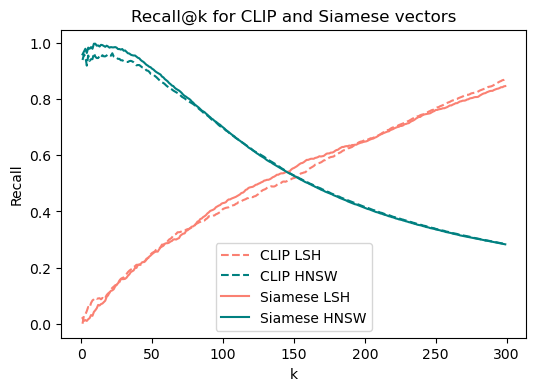

In [197]:
# plot recall curves:
plt.figure(figsize=(6,4))

# Clip results:
plt.plot(range(1,total_k), model_results["CLIP"][0], label="CLIP LSH", color="salmon", linestyle="--")
plt.plot(range(1,total_k), model_results["CLIP"][1], label="CLIP HNSW", color="teal", linestyle="--")

# Siamese results:
plt.plot(range(1,total_k), model_results["Siamese"][0], label="Siamese LSH", color="salmon")
plt.plot(range(1,total_k), model_results["Siamese"][1], label="Siamese HNSW", color="teal")

plt.title("Recall@k for CLIP and Siamese vectors")
plt.xlabel("k")
plt.ylabel("Recall")
plt.legend()

plt.show()

## Retrieval Quality Analysis

### Retrieve Similar Images and Tag Pairs

In [13]:
ir_quality_k = 5

# retrieve using HNSW index with both models:
hnsw_ann_results_siamese = faiss_search(query_vectors_siamese, hnsw_index_siamese, ir_quality_k)
hnsw_ann_results_clip = faiss_search(query_vectors_clip, hnsw_index_clip, ir_quality_k)

# find image-pairs retrieved:
image_pairs_names_siamese = []
image_pairs_names_clip = []
for i in range(len(query_image_names)):
    for k in range(ir_quality_k):
        siamese_res = index_image_names[hnsw_ann_results_siamese[i][k]]
        image_pairs_names_siamese.append((query_image_names[i], siamese_res))

        clip_res = index_image_names[hnsw_ann_results_clip[i][k]]
        image_pairs_names_clip.append((query_image_names[i], clip_res))


In [247]:
# save image pairs into a pd:
df_siamese_pairs = pd.DataFrame(image_pairs_names_siamese, columns=['query_image', 'retrieved_image'])
df_clip_pairs = pd.DataFrame(image_pairs_names_clip, columns=['query_image', 'retrieved_image'])
ir_df = pd.concat([df_siamese_pairs, df_clip_pairs], axis=0)

# add image paths:
image_path = "datasets/house_styles/all_images/"
ir_df['query_image_path'] = ["(" + image_path + img + ")" for img in ir_df['query_image']]
ir_df['retrieved_image_path'] = ["(" + image_path + img + ")" for img in ir_df['retrieved_image']]

# add similarity already in the pairs_df:
ir_df1 = ir_df.merge(pairs_df, how='left', left_on=['query_image', 'retrieved_image'], right_on=['image1', 'image2'])
ir_df1 = ir_df1.drop(columns=['image1', 'image2', 'image1_path', 'image2_path'])
ir_df1 = ir_df1.rename(columns={"similarity": "similarity1"})

ir_df2 = ir_df.merge(pairs_df, how='left', left_on=['query_image', 'retrieved_image'], right_on=['image2', 'image1'])
ir_df2 = ir_df2.drop(columns=['image1', 'image2', 'image1_path', 'image2_path'])
ir_df2 = ir_df2.rename(columns={"similarity": "similarity2"})

# combine both results by taking the max available similarity if it exists:
ir_df = pd.concat([ir_df1, ir_df2], axis=1)
ir_df['similarity'] = ir_df[['similarity1', 'similarity2']].max(axis=1)
ir_df = ir_df.drop(columns=['similarity1', 'similarity2'])

ir_df = ir_df.loc[:,~ir_df.columns.duplicated()]
ir_df = ir_df[['query_image', 'query_image_path', 'retrieved_image', 'retrieved_image_path', 'similarity']]

print("Number of retrieved image pairs: ", len(ir_df))

# remove duplicates:
ir_df = ir_df.drop_duplicates()
print("Number of unique retrieved image pairs: ", len(ir_df))
print("Number of image pairs to tag: ", len(ir_df[ir_df['similarity'].isna()]))


Number of retrieved image pairs:  500
Number of unique retrieved image pairs:  470
Number of image pairs to tag:  206


In [248]:
# save into csv:
ir_df.to_csv("datasets/house_styles/evaluation_paired_labels.csv", index=False)

### Evaluate Retrieval Quality by Tagged Pairs

In [ ]:
from collections import defaultdict

In [ ]:
hnsw_clip_names = defaultdict(list)
hnsw_siamese_names = defaultdict(list)

# Create dictionaries of retrieved image names
for i in range(len(query_image_names)):
    hnsw_clip_names[query_image_names[i]] = [index_image_names[hnsw_ann_results_clip[i][k]] for k in range(hnsw_ann_results_clip.shape[1])]
    hnsw_siamese_names[query_image_names[i]] = [index_image_names[hnsw_ann_results_siamese[i][k]] for k in range(hnsw_ann_results_siamese.shape[1])]

# Load relevance scores 
relevance_scores = pd.read_csv("datasets/house_styles/evaluation_paired_labels.csv")

# Create lists of relevance scores
relevance_clip = []
relevance_siamese = []

for query in query_image_names:
    # Get the relevance score for each retrieved image in the HNSW results of the query image for both models
    query_relevances_clip = []
    for index in hnsw_clip_names[query]:
        score = relevance_scores[(relevance_scores['query_image'] == query) & (relevance_scores['retrieved_image'] == index)]['similarity']
        if len(score) == 0:
            score = 0
        else:
            score = score.values[0]
        query_relevances_clip.append(score)
    relevance_clip.append(query_relevances_clip)
    
    query_relevances_siamese = []
    for index in hnsw_siamese_names[query]:
        score = relevance_scores[(relevance_scores['query_image'] == query) & (relevance_scores['retrieved_image'] == index)]['similarity']
        if len(score) == 0:
            score = 0
        else:
            score = score.values[0]
        query_relevances_siamese.append(score)
    relevance_siamese.append(query_relevances_siamese)


#### NDCG:

In [ ]:
# convert to numpy arrays
relevance_clip = np.array(relevance_clip)
relevance_siamese = np.array(relevance_siamese)

def dcg(relevance_scores):
    """Calculate Discounted Cumulative Gain (DCG)."""
    return np.sum((2 ** relevance_scores - 1) / np.log2(np.arange(1, len(relevance_scores) + 1) + 1))

def idcg(relevance_scores):
    """Calculate Ideal Discounted Cumulative Gain (IDCG)."""
    sorted_relevance = np.sort(relevance_scores)[::-1]  # Sort relevance scores in descending order
    return dcg(sorted_relevance)

def ndcg(relevance_scores, p=None):
    """Calculate Normalized Discounted Cumulative Gain (NDCG)."""
    # Limit to the top p results if p is specified
    if p is not None:
        relevance_scores = relevance_scores[:p]

    dcg_value = dcg(relevance_scores)
    idcg_value = idcg(relevance_scores)

    # To prevent division by zero
    if idcg_value == 0:
        return 0.0

    return dcg_value / idcg_value

def compute_average_ndcg(relevance_lists, binary=False, p=None):
    """Compute the average NDCG score for multiple queries."""

    # Convert relevance scores to binary values if specified
    if binary:
        max_relevance = np.max(relevance_lists)
        relevance_lists = (relevance_lists >= max_relevance).astype(int)

    # Calculate NDCG scores for each query
    ndcg_scores = []
    for relevance_scores in relevance_lists:
        ndcg_score = ndcg(relevance_scores, p)
        ndcg_scores.append(ndcg_score)
    
    # Calculate the average NDCG score
    average_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0.0
    return average_ndcg

# Calculate NDCG for top 5 results
ndcg_score_clip = compute_average_ndcg(relevance_clip, p=5)
ndcg_score_siamese = compute_average_ndcg(relevance_siamese, p=5)

# Calculate NDCG for binary relevance
ndcg_score_clip_binary = compute_average_ndcg(relevance_clip, binary=True, p=5)
ndcg_score_siamese_binary = compute_average_ndcg(relevance_siamese, binary=True, p=5)

# Print the NDCG scores
print("NDCG Score for clip:", ndcg_score_clip)
print("NDCG Score for siamese:", ndcg_score_siamese)
print()
print("Binary NDCG Score for clip:", ndcg_score_clip_binary)
print("Binary NDCG Score for siamese:", ndcg_score_siamese_binary)


NDCG Score for clip: 0.7202674014926145
NDCG Score for siamese: 0.7051498253617297

Binary NDCG Score for clip: 0.4283615872175545
Binary NDCG Score for siamese: 0.44060350342400484


#### MAP:

In [ ]:
def precision_at_k(relevance_scores, k):
    """Calculate Precision at each rank j up to k."""
    
    relevant_count = 0
    precision_scores = []
    
    for j in range(k):
        if j < len(relevance_scores):
            if relevance_scores[j] > 0:  # Consider this as a relevant item
                relevant_count += 1
        precision_scores.append(relevant_count / (j + 1))
    
    return precision_scores

def map_at_k(relevance_scores_list, k, binary=True, max_relevance=3):
    """Calculate MAP@k over multiple queries."""

    total_ap = 0.0
    total_queries = len(relevance_scores_list)

    # Convert relevance scores to binary if specified
    if binary:
        relevance_scores_list = [[1 if r >= max_relevance else 0 for r in relevance_scores] for relevance_scores in relevance_scores_list]
    
    # Calculate Average Precision for each query
    for relevance_scores in relevance_scores_list:
        R_q = np.sum(np.array(relevance_scores) > 0)  # Count of relevant items
        if R_q == 0:
            continue  # Skip if there are no relevant items
        
        precision_scores = precision_at_k(relevance_scores, k)
        ap = np.sum(np.array(precision_scores) * np.array(relevance_scores)) / R_q
        total_ap += ap

    # Normalize the total AP by the maximum relevance score
    if not binary:
        total_ap = total_ap / max_relevance
    
    # Calculate the final MAP@k score
    return total_ap / total_queries if total_queries > 0 else 0.0

# Define k for the top ranks to consider
k = 5  # You can change this to the number of top ranks you want to consider

# Calculate MAP@k for both relevance sets
map_k_score_clip = map_at_k(relevance_clip, k, binary=False, max_relevance=3)
map_k_score_siamese = map_at_k(relevance_siamese, k, binary=False, max_relevance=3)

# Calculate MAP@k for binary relevance for both relevance sets
map_k_score_clip_binary = map_at_k(relevance_clip, k, binary=True, max_relevance=3)
map_k_score_siamese_binary = map_at_k(relevance_siamese, k, binary=True, max_relevance=3)

# Display the results
print(f"MAP@{k} Score for clip:", map_k_score_clip) 
print(f"MAP@{k} Score for siamese:", map_k_score_siamese)
print()
print(f"MAP@{k} Score for clip (binary):", map_k_score_clip_binary)
print(f"MAP@{k} Score for siamese (binary):", map_k_score_siamese_binary)

MAP@5 Score for clip: 0.6320925925925925
MAP@5 Score for siamese: 0.8044444444444444

MAP@5 Score for clip (binary): 0.3655
MAP@5 Score for siamese (binary): 0.3904444444444444


## Qualitative Evaluation

### Visual Analysis

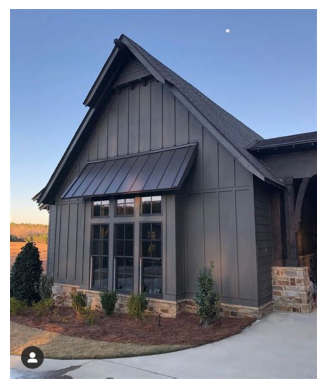

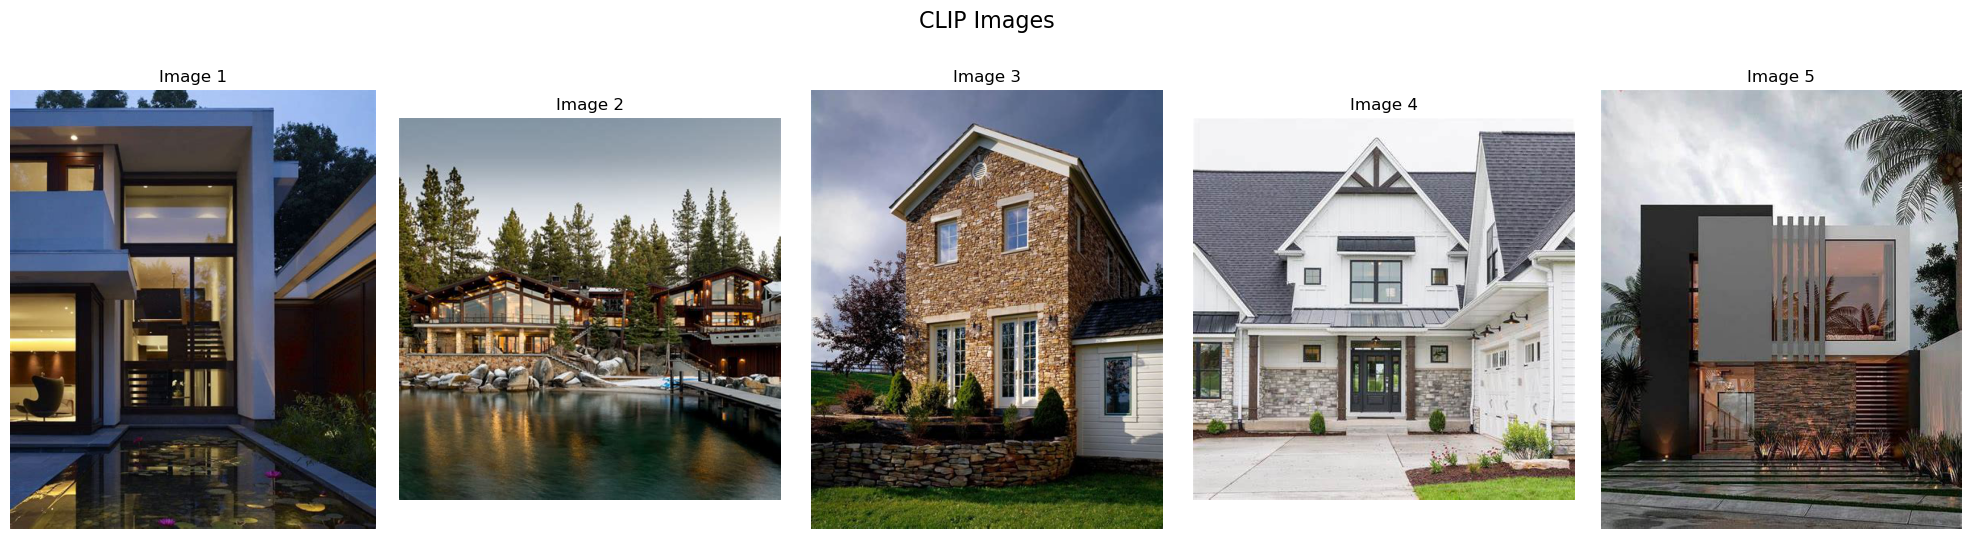

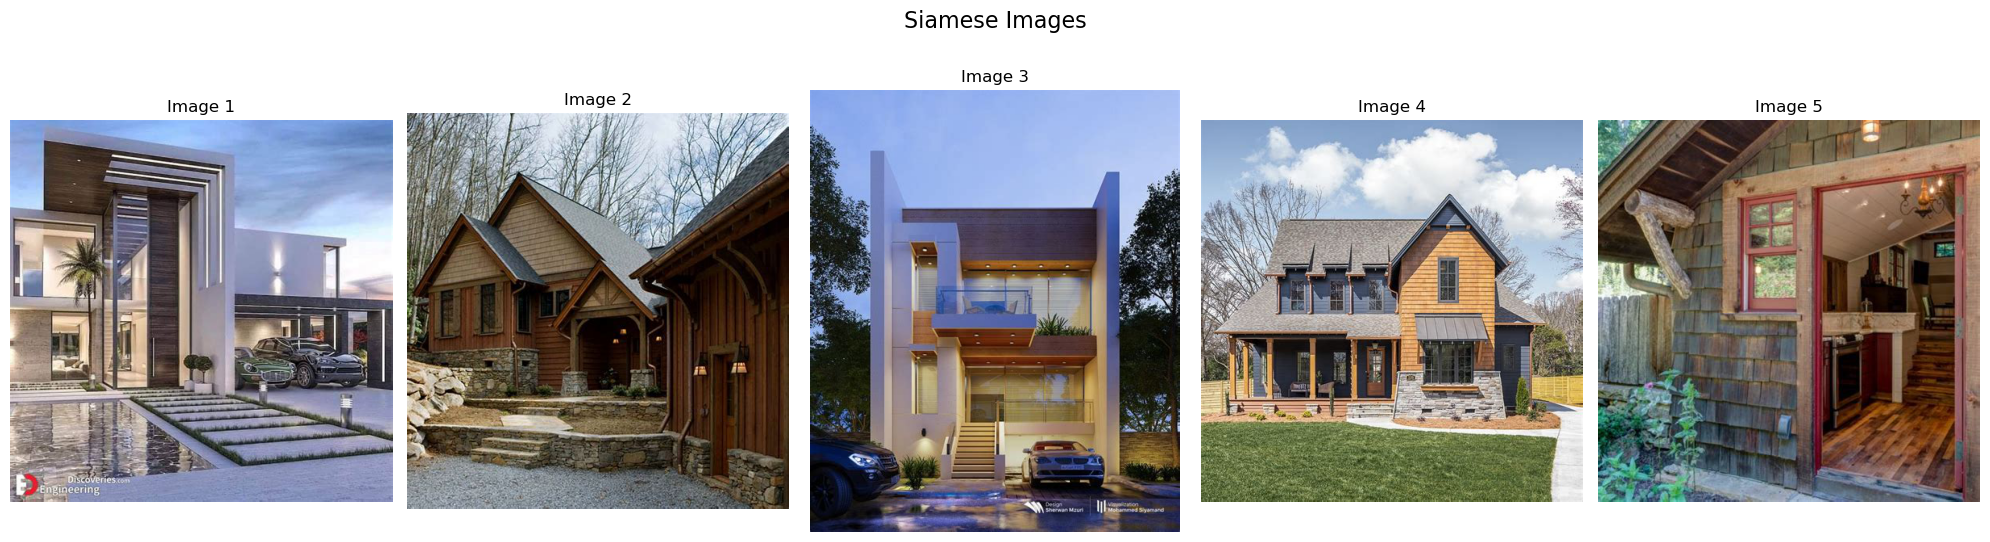

In [266]:
selected_image_num = 1

# print query the image
folder_path = 'datasets/house_styles/all_images'
image_path = os.path.join(folder_path, query_image_names[selected_image_num])
image = Image.open(image_path)
plt.axis("off") 
plt.imshow(image)

# CLIP:
retrieve_image_names = [index_image_names[i] for i in hnsw_ann_results_clip[selected_image_num]]
plt.figure(figsize=(20, 10)) 
for i, image_name in enumerate(retrieve_image_names):
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    
    # Set up a 2x5 grid
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image {i + 1}", fontsize=12)  # Add numbering
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.suptitle("CLIP Images", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Siamese:
retrieve_image_names = [index_image_names[i] for i in hnsw_ann_results_siamese[selected_image_num]]
plt.figure(figsize=(20, 10)) 
for i, image_name in enumerate(retrieve_image_names):
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    
    # Set up a 2x5 grid
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image {i + 1}", fontsize=12)  # Add numbering
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.suptitle("Siamese Images", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

### Performance by House Type

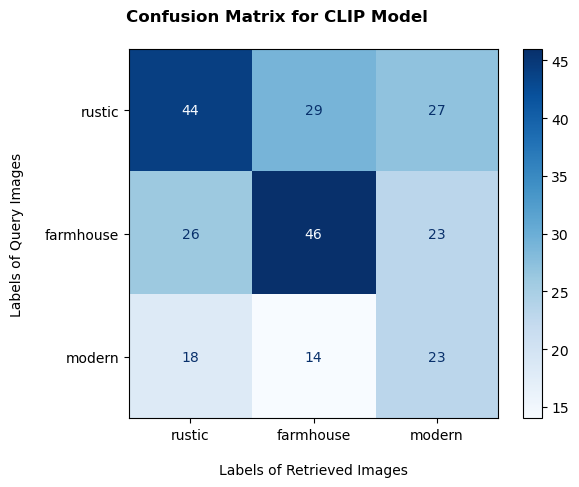

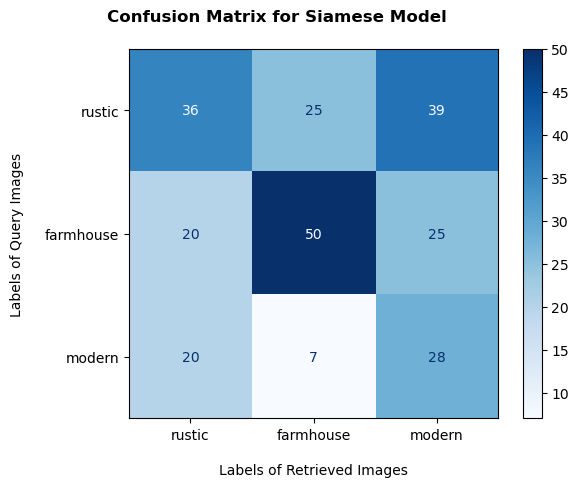

In [302]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the labels.csv file
labels_df = pd.read_csv('datasets/house_styles/labels.csv')

def plot_styles_confusion_matrix(model_index, model_name):
    # Function to get the label for a given image name
    def get_label(image_name):
        return labels_df.loc[labels_df['file_label'] == image_name, 'house_type'].values[0]

    # Example lists of query and result image names
    query_image_names_ordered = [query_image_names[i] for i in range(len(query_image_names)) for _ in range(k)]
    result_images_names = [index_image_names[idx] for img_idx_list in model_index for idx in img_idx_list]

    # Get the labels for the query and result images
    query_labels = [get_label(img) for img in query_image_names_ordered]
    result_labels = [get_label(img) for img in result_images_names]

    # Generate the confusion matrix
    cm = confusion_matrix(query_labels, result_labels, labels=['rustic', 'farmhouse', 'modern'])

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rustic', 'farmhouse', 'modern'])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(f'Confusion Matrix for {model_name} Model', fontsize=12, pad=20, fontweight='bold')
    disp.ax_.set_xlabel('Labels of Retrieved Images', fontsize=10)
    disp.ax_.set_ylabel('Labels of Query Images', fontsize=10)
    disp.ax_.xaxis.labelpad = 15
    disp.ax_.yaxis.labelpad = 15
    disp.ax_.title.set_position([0.4, 1.05])
    plt.show()

# Plot the confusion matrix for the CLIP model
plot_styles_confusion_matrix(hnsw_results_clip, 'CLIP')

# Plot the confusion matrix for the Siamese model
plot_styles_confusion_matrix(hnsw_results_siamese, 'Siamese')